In [131]:
import tensorflow as tf
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [133]:
#parametres 
img_size = 128
data_dir = r"C:\Users\21654\OneDrive\Desktop\Celebrity_Faces_Dataset"

In [135]:

def load_data(data_dir):
    images, labels = [], []
    class_names = sorted(os.listdir(data_dir))
    class_map = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(class_map[class_name])

    return np.array(images), np.array(labels), class_names

images, labels, class_names = load_data(data_dir)
images = images / 255.0  # Normalisation
print(f"Classes disponibles : {class_names}")

Classes disponibles : ['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


In [136]:
x_train , x_val , y_train , y_val = train_test_split(images, labels , test_size = 0.2 , random_state=42)

In [139]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
datagen.fit(x_train)


In [141]:
# Load Pre-Trained Model
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

In [143]:
# Add Custom Layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])
optimizer = Adam(learning_rate=0.0001)  # Lower the learning rate for fine-tuning
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,424,145 (9.25 MB)

 Trainable params: 166,161 (649.07 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [145]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [173]:
# Train the Model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=10
    
)

C:\Users\21654\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.4309 - loss: 1.7787 - val_accuracy: 0.4806 - val_loss: 1.6648
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.3850 - loss: 1.8018 - val_accuracy: 0.4556 - val_loss: 1.6538
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.4242 - loss: 1.7474 - val_accuracy: 0.4722 - val_loss: 1.6401
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.4305 - loss: 1.6805 - val_accuracy: 0.4750 - val_loss: 1.6407
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.4249 - loss: 1.6736 - val_accuracy: 0.4833 - val_loss: 1.6163
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.4465 - loss: 1.6635 - val_accuracy: 0.5000 - val_loss: 1.6035
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.4506 - loss: 1.6613 - val_accuracy: 0.4833 - val_loss: 1.6046
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.4479 - loss: 1.6215 - val_accuracy: 0

In [175]:
# Evaluate the Model
test_loss, test_acc = model.evaluate(x_val, y_val)
print(f"Test Accuracy: {test_acc}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5548 - loss: 1.5395
Test Accuracy: 0.5055555701255798


In [186]:

# Confusion Matrix and Classification Report
y_pred = model.predict(x_val).argmax(axis=1)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=class_names))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
[[ 7  0  0  0  0  0  1  0  3  2  0  0  1  3  0  0  0]
 [ 0 10  0  2  0  0  0  1  0  0  0  0  0  0  1  0  1]
 [ 1  0 12  1  0  0  0  1  0  0  0  2  0  0  0  0  4]
 [ 0  1  1 10  0  2  1  2  0  0  0  3  0  0  3  0  3]
 [ 0  0  0  0  9  0  2  0  1  4  2  0  1  4  0  0  0]
 [ 0  0  0  1  0 13  0  0  1  1  0  4  0  1  3  1  0]
 [ 2  1  0  0  1  0  9  0  0  1  3  0  0  1  0  0  0]
 [ 0  3  2  0  0  2  0  9  0  0  0  0  0  0  1  2  0]
 [ 0  0  0  0  0  0  0  0 13  2  1  0  1  1  0  0  0]
 [ 2  0  0  0  2  0  1  0  0  4  0  0  0  9  0  0  0]
 [ 0  1  1  0  1  0  0  0  1  1  8  0  0  4  0  0  0]
 [ 0  0  0  1  0  2  0  1  0  0  0  8  0  1  2  0  0]
 [ 2  0  1  0  1  0  2  0  6  3  0  0  5  2  0  0  0]
 [ 1  0  0  0  5  0  2  0  0  2  2  0  0 34  0  0  0]
 [ 0  0  0  2  0  4  1  0  0  0  0  4  0  0  8  0  0]
 [ 0  0  1  0  0  0  0  4  0  0  0  0  0  0  2  8  0]
 [ 0  3  2  0  1  0  1  0  0  0  0  3  0  1  0  0 15]]
                    precision    recall 

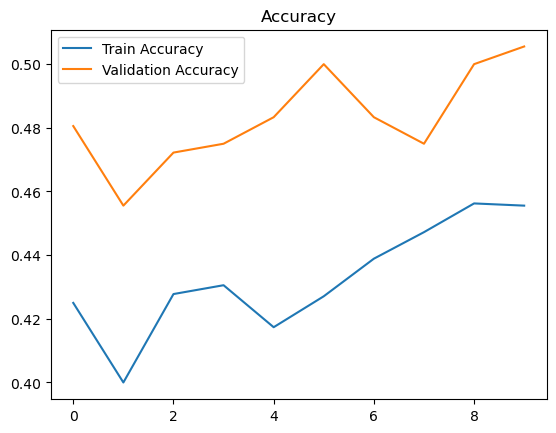

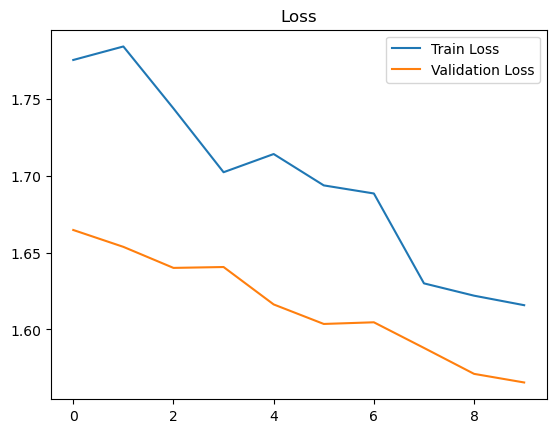

In [188]:
# Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [246]:
# Preprocess Webcam Image
def preprocess_image(img, img_size):
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Real-Time Prediction via Webcam
cap = cv2.VideoCapture(0)  # 0 for default camera
print("Press 's' to capture an image and test.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error capturing image.")
        break

    cv2.imshow("Camera", frame)

    key = cv2.waitKey(1)
    if key == ord('s'):  # Capture on 's'
        test_img = preprocess_image(frame, img_size)
        prediction = model.predict(test_img)
        predicted_class = class_names[np.argmax(prediction)]
        print(f"Predicted Class: {predicted_class}")
        break
    elif key == ord('q'):  # Quit on 'q'
        break

cap.release()
cv2.destroyAllWindows()

Press 's' to capture an image and test.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Class: Will Smith


In [ ]:
model.save()